# LE49 Exercise 2: Probabilistic Ranking

*Xiangyu Zhao*\
*Trinity College*\
*CRSid: xz398*

## Answer to Question (a)

Code for computing $\Sigma^{-1}$, `Σinv`:
```python
Σinv = np.diag(1 / pv)  # prior covariance matrix
for i in range(M):
    for j in range(M):
        if i == j:
            Σinv[i, j] += np.sum(i == G[:,0]) + np.sum(i == G[:,1])
        else:
            Σinv[i, j] -= np.dot((i == G[:,0]).astype(int), 
                                 (j == G[:,1]).astype(int)) \
                        + np.dot((i == G[:,1]).astype(int), 
                                 (j == G[:,0]).astype(int))
```
Code for computing $\tilde{\mu}$, `μtilde`:
```python
μtilde = np.zeros(M)
for i in range(M):
    μtilde[i] = np.dot(t, ((i == G[:,0]).astype(int) 
                           - (i == G[:,1]).astype(int)))
```
I sampled the player who ranked top on the crude rank (Novak Djokovic, 67/74 games won), the player who ranked at the median of the crude rank (Sam Querrey, 12/28 games won), the player who ranked lowest on the crude rank with at least 10 games played (Rui Machado, 3/16 games won), and the player who ranked lowest on the crude rank (Jean Julien Rojer, 0/1 game won). Their skills with respect to the iterations are shown in the following plots:

![](Question(a)/skills_wrt_epochs.png)

Several conclusions can be drawn from the above plots:
* the player with a higher win rate tend to have a higher mean skill;
* the player with less games played tend to have a higher variance on the skills across the iterations. (Since Jean Julien Rojer had too few games played, his skills have a very high variance across the iterations, and is not necessarily the lowest of all players.)

The plots show that within a short time period (i.e. ~50 epochs), the skills vary significantly; however, on the global perspective, the distribution of the sampled skills seems stable (i.e. having a fixed mean and variance), therefore I can infer that the Gibbs sampler is able to move around the whole posterior distribution.

The autocorrelations of the skills of the previous players are plotted in the below plots:

![](Question(a)/autocorrelations.png)

A smaller autocorrelation means less independence between the samples with the given lag. If the autocorrelation is close to zero, then the samples with the given lag can be treated as independent. The mixing time of a Gibbs sampler is the minimum time necessary for the total variation distance between the distribution of the Gibbs sampler's current state and its stationary distribution to fall below some $\epsilon>0$. The burn-in time is the number of initial samples to be discarded in order for the Gibbs sampler to generate pseudo-independent samples. By computing the autocorrelations and setting $\epsilon=10^{-3}$, the mean and standard deviation of the mixing times for the players can be found as the following:

$$\mu\approx46.9065\qquad\sigma\approx35.5342$$

Therefore, it is sensible to set the burn-in time for the Gibbs sampler to be $\mu+1.96\sigma\approx116.5537$ epochs. Besides, from the autocorrelation plots, it can be seen that once the Gibbs sampler converges to a steady state, its autocorrelation crosses through zero roughly at every 10 samples, therefore it is also sensible to apply thinning to the Gibbs sampler by keeping only every 10th sample, in order to get less dependence between the samples.

Below are the updated plots of the skills of the same players as the above, after applying a burn-in that discards 120 initial samples and a thinning by keeping only every 10th sample to the Gibbs sampler:

![](Question(a)/skills_wrt_epochs_burnin_thinning.png)

It can be seen from the updated plots that the distributions of the skills now become much stabler, and the findings from the original skill plots still hold.

## Answer to Question (b)

I ran `gaussian_ep` for 200 iterations and plotted the means and stand deviations of ths skills of the same players I plotted in Question (a) with respect to the iterations as follow:

![](Question(b)/means_stds_wrt_epochs.png)

By inspection, both the means and standard deviations seems to converge within 25 iterations. By setting the convergence threshold to be 1%, the mean and standard deviation of the convergence times for the means of the players' skills are:

$$\mu_{\text{Conv}_{\mu_s}}\approx41.5421\qquad\sigma_{\text{Conv}_{\mu_s}}\approx12.6042$$

Similarly, the mean and standard deviation of the convergence times for the standard deviaitions of the players' skills are:

$$\mu_{\text{Conv}_{\sigma_s}}\approx2.1869\qquad\sigma_{\text{Conv}_{\sigma_s}}\approx0.5318$$

Since it takes longer for the means to converge than the standard deviations for all players, the convergence time for the means should be adapted. 

## Answer to Question (c)

For the Gibbs sampler, the goal is to generate pseudo-independent samples from the joint distribution, so convergence in this context means that the behaviour of the conditional posterior distribution (i.e. mean and variance) stays stable, after the burn-in and mixing time. Eventually, what a Gibbs sampler converges to is a distribution from which samples are jointly drawn. Since the Gibbs sampler converges the distribution itself, it can be challenging to judge when the convergence is achieved. Sometimes several Gibbs samplers are run from different initial random seeds, and the results are compared to judge convergence. Alternatively, one can summarise different chunks of the samples, and compare the results to determine convergence.

In message passing, the marginal distributions are approximated to be Gaussian, so only the means and variances are used as the messages. Therefore, convergence in this context means that the means and variances of the Gaussian stay stable. In mathematical terms, let $q^\tau(w_i)$ denote the mean and variance of the marginal skills at iteration $\tau$, then perfect convergence is achieved when

$$q^{\tau+1}(w_i)=q^\tau(w_i)$$

In practice, I use the following threshold to determine the number of iterations required for convergence in message passing:

$$\left|\frac{q^\tau(w_i)-q^\infty(w_i)}{q^\infty(w_i)}\right|<0.01$$

where $\infty$ can be an arbitrary number of iterations that are long enough for the message passing to show a clear converging pattern, for example, 200 iterations in this case.

Below are plots of the players' skills in Question (a), annotated with a ribbon plot of $\mu\pm1.96\sigma$ that I found in Question (b) (here I used the final converged results):
 
![](Question(c)/skills_wrt_epochs_mean_std.png)

The means and standard deviations obtained via message passing in Question (b) fit nicely to the sample distributions from the Gibbs sampler in Question (a), and is almost the same as the means and the standard deviations of the conditioal posterior produced by the Gibbs sampler (having already applied burn-in and mixing). This because not only the message passing approximates the marginal distributions to be Gaussian, the conditional posterior distributions by the Gibbs sampler are also Gaussian, which means that both algorithms converge to the same distribution (only in different ways), and it is natural that they produce the same means and standard deviations, which also cross-validates good convergence for both models. The below diagram shows the means and standard deviations of all players by both the Gibbs sampler and the message passing algorithm, showing close mean and standard deviation results for all players:

![](Question(c)/skills_comparison.png)

The orders of the players in means obtained from both the Gibbs sampler and the message passing algorithm are also close to the crude ranking of the players. Note that the means' orders are NOT the exact ways to predict ranking for either model; we should rank the players by the probabilities of winning against other players instead. I will elaborate this in my answer to Question (d).

## Answer to Question (d)

Both the Gibbs sampler and message passing assumes the marginal distributions of the players' skills to be Gaussian:

$$w_i\sim N(\mu_i,\sigma^2_i)\qquad w_j\sim N(\mu_j,\sigma^2_j)$$

Assuming the skills are independent, then:

$$w_i-w_j\sim N(\mu_i-\mu_j,\sigma^2_i+\sigma^2_j)$$

When calculating the probability that Nadal would beat Djokovic in a match, a noise $n\sim N(0,1)$ should be added to account for performance inconsistency. Therefore:

$$w_i-w_j+n\sim N(\mu_i-\mu_j,\sigma^2_i+\sigma^2_j+1)$$

For calculating the probabilities using the joint samples from the Gibbs sampler directly, I counted the number of samples (having taken account of burn-in and thinning) where Nadal's skill is higher than Djokovics (and added appropriate noises if calculating the probabilities of Nadal beating Djokovic), and calculated its probability among all samples. 

The calculated six probabilities are shown in the following table:

| | Gibbs sampler | Gibbs sampler, direct | Message passing |
| :---                                    |   ---: |   ---: |   ---: |
| $p(\text{Nadal's skill is higher than Djokovic})\\=p(w_\text{Nadal}-w_\text{Djokovic}>0)$ | 0.0753 | 0.0606 | 0.0602 |
| $p(\text{Nadal beats Djokovic in a match})\\=p(w_\text{Nadal}-w_\text{Djokovic}+n>0)$ | 0.3680 | 0.2828 | 0.3719 |

All three probabilities that Nadal's skill is higher than Djokovic are similar, and so are the three probabilities that Nadal would beat Djokovic in a match. This is because all three methods are sampling from the same Gaussian distribution, with only very subtle differences. I think the probability that Nadal would beat Djokovic in a match by directly using the joint samples from the Gibbs sampler is the best way to compare Nadal and Djokovic, because:
* Firstly, this probability takes into account for performance inconsistency, which relates more closely to the real-world scenario; in contrast, the probabilities that Nadal's skill is higher than Djokovic all look very one-sided. In fact, the head-to-head results of Nadal versus Djokovic is 28 wins, 30 losses. (source: [ATP Tour](https://www.atptour.com/en/players/atp-head-2-head/novak-djokovic-vs-rafael-nadal/D643/N409)) 
* Secondly, calculating the probability directly from the joint samples makes less assumption than using the marginal distributions, which can be more accurate since the marginal distributions are not exactly Gaussian, and both the Gibbs sampler and message passing are only approximating it to be Gaussian.

Below are the diargrams of ranking all the players in the dataset, by broadcasting the six probabilities to all players:

![](Question(d)/rankings_comparison.png)

## Answer to Question (e)

Let $\mathbf{x}=[x_{1851},x_{1852},\cdots,x_{1961}]$, where $x_i$ is the number of explosions in year $i$. Let $N$ denote the number of years that $\theta$ can take.

The full posterior distribution is (here I use $\text{Poission}(x|\lambda)$ to denote $\Pr(x)$ where $x\sim\text{Poission}(\lambda)$, and $\text{Gamma}(x|a,b)$ to denote $p(x)$ for $x\sim\text{Gamma}(a,b)$, apologies for the abuse of notations)

$$\begin{align}
p(\lambda,\mu,\theta|\mathbf{x},a,b) &\propto \Pr(x_{1851},\cdots,x_\theta|\lambda)\Pr(x_{\theta+1},\cdots,x_{1961}|\mu)p(\lambda|a,b)p(\mu|a,b)\Pr(\theta) \\
    &= \text{Poisson}(x_{1851},\cdots,x_\theta|\lambda)\text{Poisson}(x_{\theta+1},\cdots,x_{1961}|\mu)\text{Gamma}(\lambda|a,b)\text{Gamma}(\mu|a,b)\frac{1}{N}
\end{align}$$

The conditional distribution for $\lambda$ is

$$\begin{align}
p(\lambda|x_{1851},\cdots,x_\theta,\theta,a,b) &\propto \text{Poisson}(x_{1851},\cdots,x_\theta|\lambda)\text{Gamma}(\lambda|a,b) \\
    &= \left(\prod_{i=1851}^{\theta}\frac{\lambda^{x_i}e^{-\lambda}}{x_i!}\right)\left(\frac{b^a}{\Gamma(a)}\lambda^{a-1}e^{-b\lambda}\right) \\
    &\propto e^{-(\theta-1851+1)\lambda}\lambda^{\sum_{i=1851}^\theta x_i}\lambda^{a-1}e^{-b\lambda} \\
    &= \lambda^{a+\sum_{i=1851}^\theta x_i - 1}e^{-(b+\theta-1851+1)\lambda}
\end{align}$$

Note that I have dropped the $x_i!$ terms and the $\frac{b^a}{\Gamma(a)}$ term, because those are constants. Therefore

$$\lambda|x_{1851},\cdots,x_\theta,\theta,a,b\sim\text{Gamma}(a+\sum_{i=1851}^\theta x_i, b+\theta-1851+1)$$

Similarly, we can obtain the conditional distribution for $\mu$:

$$\mu|x_{\theta+1},\cdots,x_{1961},\theta,a,b\sim\text{Gamma}(a+\sum_{i=\theta+1}^{1961} x_i, b+1961-\theta)$$

The conditional distribution for $\theta$ is (note that the term $\Pr(\theta)=\frac{1}{N}$ has been dropped, because it is a constant)

$$\begin{align}
p(\theta|\mathbf{x},\lambda,\mu) &\propto \text{Poisson}(x_{1851},\cdots,x_\theta|\lambda)\text{Poisson}(x_{\theta+1},\cdots,x_{1961}|\mu) \\
    &= \left(\prod_{i=1851}^{\theta}\frac{\lambda^{x_i}e^{-\lambda}}{x_i!}\right)\left(\prod_{i=\theta+1}^{1961}\frac{\mu^{x_i}e^{-\mu}}{x_i!}\right) \\
    &\propto \lambda^{\sum_{i=1851}^\theta x_i}e^{-(\theta-1851+1)\lambda}\mu^{\sum_{i=\theta+1}^{1961} x_i}e^{-(1961-\theta)\mu}
\end{align}$$

I set $a$ to be the mean of the number of explosions of the entire interval (1852–1961), and $b$ to be 1. I also set the prior $\theta$ to be 1900. The code I wrote for the Gibbs sampler for this question is:
```python
N = len(df)
x = df['count']
a = np.mean(x)
b = 1
# Here I set df['year'][1] (i.e. 1852) to be year 0 as opposed to my maths derivations
θ = 1900 - df['year'][1]  # prior θ
λs = []
μs = []
θs = [θ]

for epoch in range(2000):
    # Sample λ (rate before change point) given x, θ, a and b 
    λ = np.random.gamma(
        shape=a + np.sum(x[:θ + 1]),
        scale=1 / (b + θ)
    )
    λs.append(λ)
    
    # Sample μ (rate after change point) given x, θ, a and b 
    μ = np.random.gamma(
        shape=a + np.sum(x[θ + 1:]),
        scale=1 / (b + N - θ)
    )
    μs.append(μ)
    
    # Sample θ given x, λ and μ
    θ_probs = np.array([(λ ** np.sum(x[:t + 1])) * np.exp(-t * λ) \
                         * (μ ** np.sum(x[t + 1:])) * np.exp(-(N - t) * μ)
                         for t in range(N)])
    θ_probs /= np.sum(θ_probs)
    θ = np.random.choice(a=np.array(df['year'] - df['year'][1]), p=θ_probs)
    θs.append(θ)
```

I ran my Gibbs sampler for 2000 iterations, and the values of $\lambda$, $\mu$, $\theta$ with repect to the iterations are shown in the following plots:

![](Question(e)/lambda_mu_theta_wrt_epochs.png)

The means, standard deviations, and 95% confidence intervals of $\lambda$, $\mu$, $\theta$ are shown in the following table:

| Parameter |   Mean |   Std. | 95% confidence interval |
| :-------: | -----: | -----: |                    ---: |
| $\lambda$ | 3.1296 | 0.3058 |        (2.5302, 3.7289) |
| $\mu$     | 0.9209 | 0.1190 |        (0.6876, 1.1542) |
| $\theta$  |   1890 | 2.4885 |            (1885, 1895) |

Below is the bar chart of mine explosions per year with $\theta$ estimated by my Gibbs sampler annotated:

![](Question(e)/mine_explosions_with_changing_point.png)

## Appendix: Full Source Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.io, scipy.stats, scipy.linalg
from numpy.linalg import solve
import requests, io
import pickle
import IPython

In [2]:
def init_random_seed(seed=42):
    np.random.seed(seed)

In [3]:
r = requests.get('https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/tennis_data.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    W = np.concatenate(data['W'].squeeze())
    G = data['G'] - 1   # W[G[i,0]] is winner of game i, W[G[i,1]] is loser
    M = W.shape[0]      # number of players M = 107
    N = G.shape[0]      # number of games N = 1801

M, N

(107, 1801)

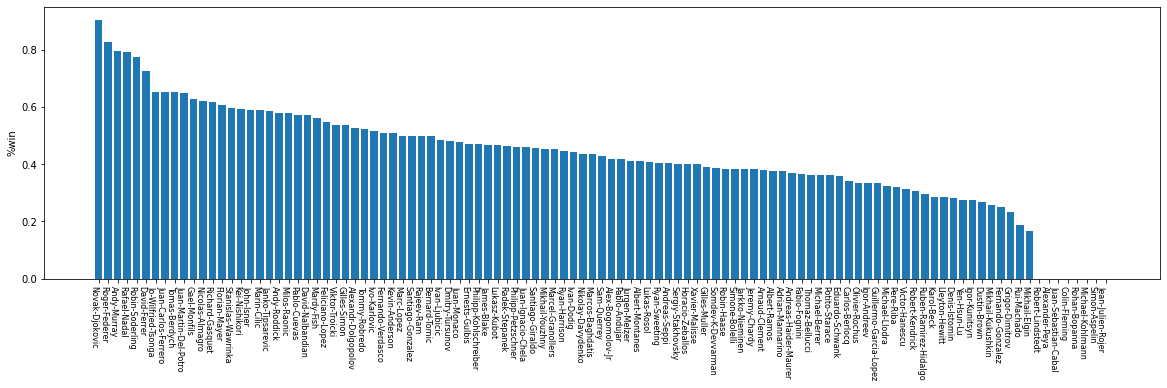

In [4]:
wins = np.zeros(M, dtype=int)
losses = np.zeros(M, dtype=int)
w, x = np.unique(G[:,0], return_counts=True)
wins[w] = x
w, x = np.unique(G[:,1], return_counts=True)
losses[w] = x
score = wins / (wins + losses)
rank_order = np.argsort(score)[::-1]

fig,ax = plt.subplots(figsize=(20,5))
x = np.arange(M)
ax.bar(x, score[rank_order], align='center', width=.8)
ax.set_xticks(x)
ax.set_xticklabels(W[rank_order], rotation=-90, ha='right', fontsize=8)
ax.set_ylabel('%win')
plt.show()

In [5]:
# Question (a)
init_random_seed()
epochs = 1100

pv = 0.5 * np.ones(M)   # prior variance
w = np.zeros(M)         # skills, initialized to be the prior mean μ0 = 0
ws = [w]

# I moved the computation of Σinv outside the for loop, because its values
# are constant and there is no need to re-compute the matrix on every epoch.
Σinv = np.diag(1 / pv)  # prior covariance matrix
for i in range(M):
    for j in range(M):
        if i == j:
            Σinv[i, j] += np.sum(i == G[:,0]) + np.sum(i == G[:,1])
        else:
            Σinv[i, j] -= np.dot((i == G[:,0]).astype(int), (j == G[:,1]).astype(int)) + np.dot((i == G[:,1]).astype(int), (j == G[:,0]).astype(int))
Σ = np.linalg.inv(Σinv)

for epoch in range(epochs):
    # Sample performance differences (t) given skills (w) and outcomes (G)
    s = w[G[:,0]] - w[G[:,1]]
    σ = 1
    t = s + σ * scipy.stats.norm.ppf(1 - np.random.uniform(size=N)*(1-scipy.stats.norm.cdf(-s/σ)))

    # Sample skills given performance differences
    μtilde = np.zeros(M)
    for i in range(M):
        μtilde[i] = np.dot(t, ((i == G[:,0]).astype(int) - (i == G[:,1]).astype(int)))
    μ = Σ @ μtilde
    w = np.random.multivariate_normal(mean=μ, cov=Σ)
    ws.append(w)
    
    IPython.display.clear_output(wait=True)
    print(f'{epoch + 1}/{epochs} epochs completed.')

ws = np.stack(ws)
with open('Question(a)/skills_wrt_epochs.pickle', 'wb') as f:
    pickle.dump(ws, f)

1100/1100 epochs completed.


In [6]:
W[rank_order]

array(['Novak-Djokovic', 'Roger-Federer', 'Andy-Murray', 'Rafael-Nadal',
       'Robin-Soderling', 'David-Ferrer', 'Jo-Wilfried-Tsonga',
       'Juan-Carlos-Ferrero', 'Tomas-Berdych', 'Juan-Martin-Del-Potro',
       'Gael-Monfils', 'Nicolas-Almagro', 'Richard-Gasquet',
       'Florian-Mayer', 'Stanislas-Wawrinka', 'Kei-Nishikori',
       'John-Isner', 'Marin-Cilic', 'Janko-Tipsarevic', 'Andy-Roddick',
       'Milos-Raonic', 'Pablo-Cuevas', 'David-Nalbandian', 'Mardy-Fish',
       'Feliciano-Lopez', 'Viktor-Troicki', 'Gilles-Simon',
       'Alexandr-Dolgopolov', 'Tommy-Robredo', 'Ivo-Karlovic',
       'Fernando-Verdasco', 'Kevin-Anderson', 'Marc-Lopez',
       'Santiago-Gonzalez', 'Rajeev-Ram', 'Bernard-Tomic',
       'Ivan-Ljubicic', 'Dmitry-Tursunov', 'Juan-Monaco',
       'Ernests-Gulbis', 'Philipp-Kohlschreiber', 'James-Blake',
       'Lukasz-Kubot', 'Radek-Stepanek', 'Philipp-Petzschner',
       'Juan-Ignacio-Chela', 'Santiago-Giraldo', 'Mikhail-Youzhny',
       'Marcel-Granollers'

In [7]:
score[rank_order]

array([0.90540541, 0.82857143, 0.79661017, 0.79166667, 0.775     ,
       0.72463768, 0.65217391, 0.65217391, 0.65079365, 0.64814815,
       0.62790698, 0.62068966, 0.61702128, 0.60714286, 0.5952381 ,
       0.59183673, 0.59090909, 0.58928571, 0.58730159, 0.57894737,
       0.57894737, 0.57142857, 0.57142857, 0.56140351, 0.54716981,
       0.53703704, 0.53703704, 0.52727273, 0.52173913, 0.51515152,
       0.5106383 , 0.50980392, 0.5       , 0.5       , 0.5       ,
       0.5       , 0.48484848, 0.48275862, 0.47826087, 0.47222222,
       0.46938776, 0.46875   , 0.46875   , 0.46511628, 0.45945946,
       0.45945946, 0.45652174, 0.45238095, 0.45238095, 0.44444444,
       0.44186047, 0.43589744, 0.43589744, 0.42857143, 0.41860465,
       0.41666667, 0.41176471, 0.41025641, 0.40740741, 0.40540541,
       0.4047619 , 0.4       , 0.4       , 0.4       , 0.39130435,
       0.38709677, 0.38461538, 0.38461538, 0.38461538, 0.38461538,
       0.38095238, 0.375     , 0.375     , 0.36842105, 0.36585

In [8]:
wins[rank_order]

array([67, 58, 47, 57, 31, 50, 45, 15, 41, 35, 27, 36, 29, 34, 25, 29, 26,
       33, 37, 22, 22, 12, 16, 32, 29, 29, 29, 29, 12, 17, 24, 26,  1,  1,
        5, 16, 16, 14, 22, 17, 23, 15, 15, 20, 17, 17, 21, 19, 19, 12, 19,
       17, 17, 12, 18, 15, 14, 16, 11, 15, 17, 14,  6, 16,  9, 12, 15,  5,
       15, 10,  8, 12, 12,  7, 15, 12, 12, 13,  5, 13,  8, 13, 12, 10,  9,
       10,  4,  5,  4,  4,  7,  8,  8,  4,  9,  2,  7,  3,  1,  0,  0,  0,
        0,  0,  0,  0,  0])

In [9]:
(wins + losses)[rank_order]

array([74, 70, 59, 72, 40, 69, 69, 23, 63, 54, 43, 58, 47, 56, 42, 49, 44,
       56, 63, 38, 38, 21, 28, 57, 53, 54, 54, 55, 23, 33, 47, 51,  2,  2,
       10, 32, 33, 29, 46, 36, 49, 32, 32, 43, 37, 37, 46, 42, 42, 27, 43,
       39, 39, 28, 43, 36, 34, 39, 27, 37, 42, 35, 15, 40, 23, 31, 39, 13,
       39, 26, 21, 32, 32, 19, 41, 33, 33, 36, 14, 38, 24, 39, 36, 31, 28,
       32, 13, 17, 14, 14, 25, 29, 29, 15, 35,  8, 30, 16,  6,  1,  3,  2,
        1,  4,  1,  1,  1])

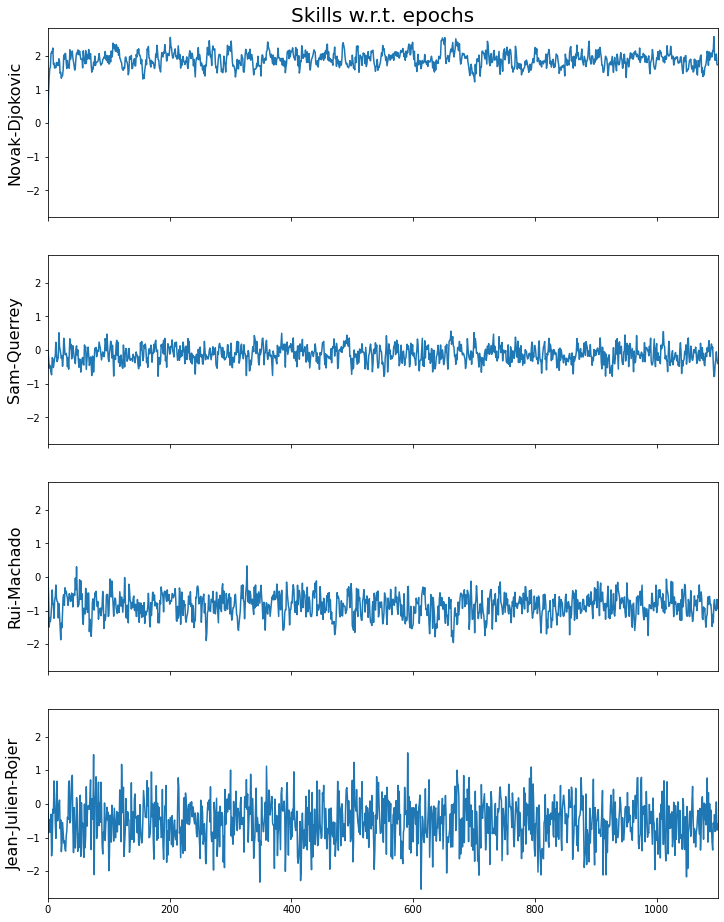

In [6]:
with open('Question(a)/skills_wrt_epochs.pickle', 'rb') as f:
    ws = pickle.load(f)

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True, sharey=True)
ranks_to_plot = [0, 53, 97, 106]
players = [W[rank_order][rank] for rank in ranks_to_plot]
player_ids = [W.tolist().index(player) for player in players]
for i, (player_id, player) in enumerate(zip(player_ids, players)):
    axes[i].plot(np.arange(epochs + 1), ws[:, player_id])
    axes[i].set_xlim(0, epochs)
    axes[i].set_ylabel(player, fontsize=16)
axes[0].set_title('Skills w.r.t. epochs', fontsize=20)
plt.savefig('Question(a)/skills_wrt_epochs.png', bbox_inches='tight')
plt.show()

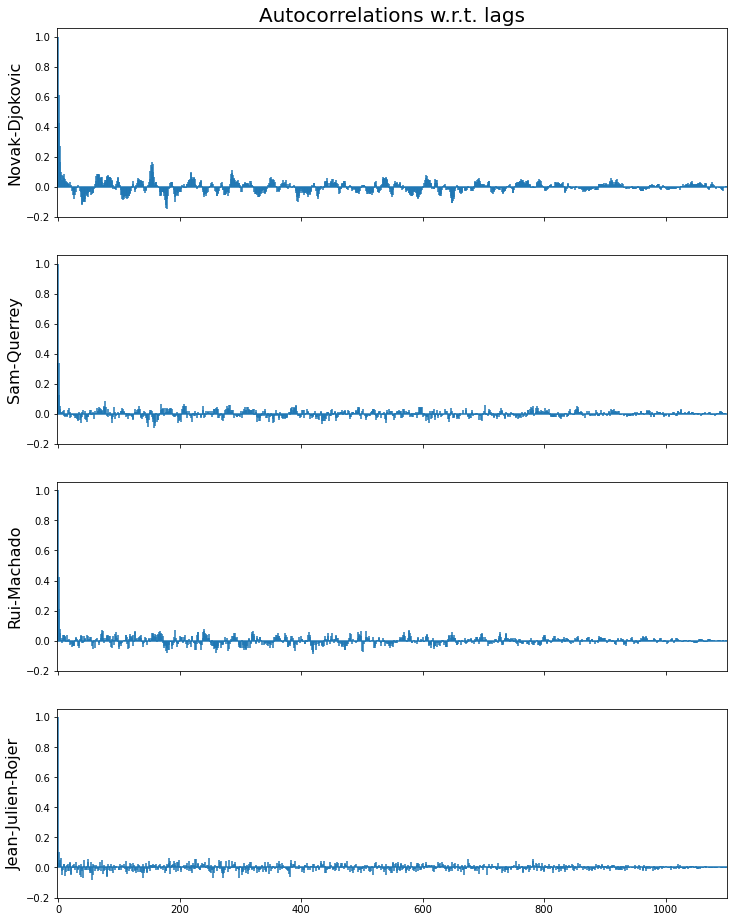

In [7]:
with open('Question(a)/skills_wrt_epochs.pickle', 'rb') as f:
    ws = pickle.load(f)

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True, sharey=True)
ranks_to_plot = [0, 53, 97, 106]
players = [W[rank_order][rank] for rank in ranks_to_plot]
player_ids = [W.tolist().index(player) for player in players]
for i, (player_id, player) in enumerate(zip(player_ids, players)):
    w = ws[:, player_id]
    axes[i].acorr(w - np.mean(w), maxlags=epochs)
    axes[i].set_xlim(-1, epochs + 1)
    axes[i].set_ylabel(player, fontsize=16)
axes[0].set_title('Autocorrelations w.r.t. lags', fontsize=20)
plt.savefig('Question(a)/autocorrelations.png', bbox_inches='tight')
plt.show()

In [12]:
with open('Question(a)/skills_wrt_epochs.pickle', 'rb') as f:
    ws = pickle.load(f)

burn_in = []
for player_id in range(M):
    w = ws[:, player_id]
    _, c, _, _ = plt.acorr(w - np.mean(w), maxlags=epochs)
    c = c[epochs:]
    burn_in.append(np.where(np.abs(c) < 0.001)[0][0])
plt.close()
np.mean(burn_in), np.std(burn_in)

(46.90654205607477, 35.53424903382319)

In [13]:
np.mean(burn_in) + 1.96 * np.std(burn_in)

116.55367016236822

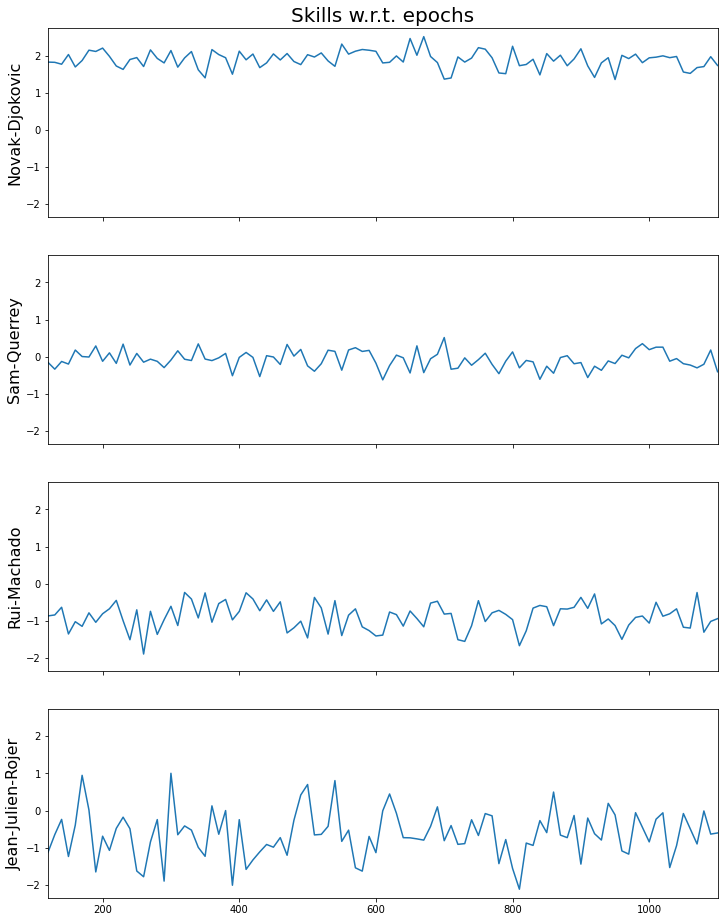

In [8]:
with open('Question(a)/skills_wrt_epochs.pickle', 'rb') as f:
    ws = pickle.load(f)

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True, sharey=True)
ranks_to_plot = [0, 53, 97, 106]
players = [W[rank_order][rank] for rank in ranks_to_plot]
player_ids = [W.tolist().index(player) for player in players]
for i, (player_id, player) in enumerate(zip(player_ids, players)):
    axes[i].plot(np.arange(120, epochs + 1, 10), ws[120::10, player_id])
    axes[i].set_xlim(120, epochs)
    axes[i].set_ylabel(player, fontsize=16)
axes[0].set_title('Skills w.r.t. epochs', fontsize=20)
plt.savefig('Question(a)/skills_wrt_epochs_burnin_thinning.png', bbox_inches='tight')
plt.show()

In [9]:
# Question (b)
def gaussian_ep(G, M):
    def Ψ(x): return scipy.stats.norm.pdf(x) / scipy.stats.norm.cdf(x)
    def Λ(x): return Ψ(x) * (Ψ(x) + x)
    N = len(G)

    μ_s, p_s = np.empty(M), np.empty(M)
    μ_gs, p_gs = np.zeros((N,2)), np.zeros((N,2))
    μ_sg, p_sg = np.empty((N,2)), np.empty((N,2))
    
    while True:
        # 1. Compute marginal skills
        # Let skills be N(μ_s, 1/p_s)
        p_s = np.ones(M) * 1/0.5
        μ_s = np.zeros(M)
        for j,(winner,loser) in enumerate(G):
            p_s[winner] += p_gs[j,0]
            p_s[loser] += p_gs[j,1]
            μ_s[winner] += μ_gs[j,0] * p_gs[j,0]
            μ_s[loser] += μ_gs[j,1] * p_gs[j,1]
        μ_s = μ_s / p_s

        # 2. Compute skill -> game messages
        # winner's skill -> game: N(μ_sg[,0], 1/p_sg[,0])
        # loser's skill -> game: N(μ_sg[,1], 1/p_sg[,1])
        p_sg = p_s[G] - p_gs
        μ_sg = (p_s[G]*μ_s[G] - p_gs*μ_gs) / p_sg

        # 3. Compute game -> performance messages
        v_gt = 1 + np.sum(1/p_sg, 1)
        σ_gt = np.sqrt(v_gt)
        μ_gt = μ_sg[:,0] - μ_sg[:,1]

        # 4. Approximate the marginal on performance differences
        μ_t = μ_gt + σ_gt * Ψ(μ_gt/σ_gt)
        p_t = 1 / v_gt / (1-Λ(μ_gt/σ_gt))

        # 5. Compute performance -> game messages
        p_tg = p_t - 1/v_gt
        μ_tg = (μ_t*p_t - μ_gt/v_gt) / p_tg

        # 6. Compute game -> skills messages
        # game -> winner's skill: N(μ_gs[,0], 1/p_gs[,0])
        # game -> loser's skill: N(μ_gs[,1], 1/p_gs[,1])
        p_gs[:,0] = 1 / (1 + 1/p_tg + 1/p_sg[:,1])  # winners
        p_gs[:,1] = 1 / (1 + 1/p_tg + 1/p_sg[:,0])  # losers
        μ_gs[:,0] = μ_sg[:,1] + μ_tg
        μ_gs[:,1] = μ_sg[:,0] - μ_tg
        
        yield (μ_s, np.sqrt(1/p_s))

In [10]:
g = gaussian_ep(G, M)
means = []
stds = []
epochs = 200

for _ in range(epochs):
    μ_s, σ_s = next(g)
    means.append(μ_s)
    stds.append(σ_s)

means = np.stack(means)
with open('Question(b)/means.pickle', 'wb') as f:
    pickle.dump(means, f)
stds = np.stack(stds)
with open('Question(b)/stds.pickle', 'wb') as f:
    pickle.dump(stds, f)

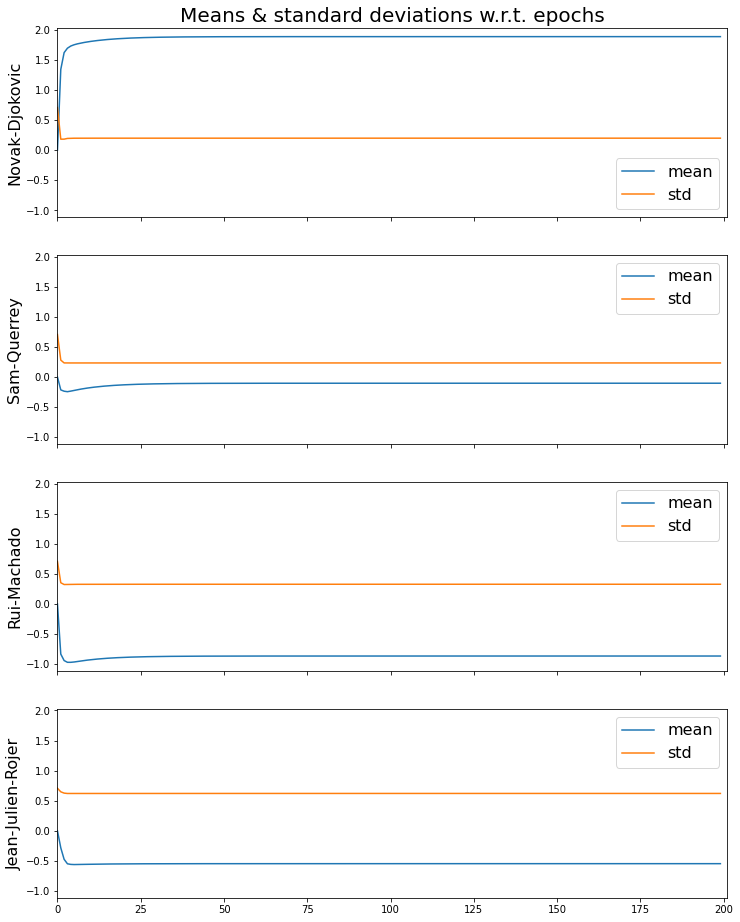

In [11]:
with open('Question(b)/means.pickle', 'rb') as f:
    means = pickle.load(f)
with open('Question(b)/stds.pickle', 'rb') as f:
    stds = pickle.load(f)

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True, sharey=True)
ranks_to_plot = [0, 53, 97, 106]
players = [W[rank_order][rank] for rank in ranks_to_plot]
player_ids = [W.tolist().index(player) for player in players]
for i, (player_id, player) in enumerate(zip(player_ids, players)):
    axes[i].plot(np.arange(epochs), means[:, player_id], label='mean')
    axes[i].plot(np.arange(epochs), stds[:, player_id], label='std')
    axes[i].set_xlim(0, epochs + 1)
    axes[i].set_ylabel(player, fontsize=16)
    if i == 0:
        axes[i].legend(fontsize=16, loc='lower right')
    else:
        axes[i].legend(fontsize=16)
axes[0].set_title('Means & standard deviations w.r.t. epochs', fontsize=20)
plt.savefig('Question(b)/means_stds_wrt_epochs.png', bbox_inches='tight')
plt.show()

In [18]:
Δmeans = (means - means[-1]) / means[-1]
means_convergence = [np.where(np.abs(Δmeans[:, i]) < 0.01)[0][0] for i in range(M)]
np.mean(means_convergence), np.std(means_convergence)

(41.54205607476636, 12.604168108863105)

In [19]:
Δstds = (stds - stds[-1]) / stds[-1]
stds_convergence = [np.where(np.abs(Δstds[:, i]) < 0.01)[0][0] for i in range(M)]
np.mean(stds_convergence), np.std(stds_convergence)

(2.1869158878504673, 0.5318077286152073)

In [20]:
convergence = [max(means_convergence[i], stds_convergence[i]) for i in range(M)]
np.mean(convergence), np.std(convergence)

(41.54205607476636, 12.604168108863105)

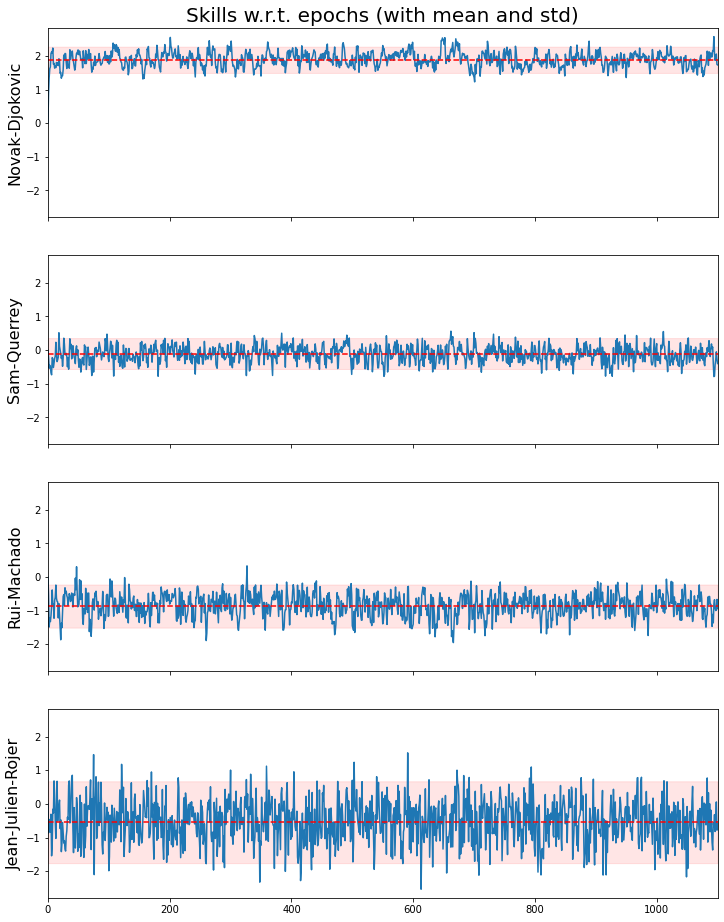

In [12]:
# Question (c)
with open('Question(a)/skills_wrt_epochs.pickle', 'rb') as f:
    ws = pickle.load(f)
with open('Question(b)/means.pickle', 'rb') as f:
    means = pickle.load(f)
with open('Question(b)/stds.pickle', 'rb') as f:
    stds = pickle.load(f)

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True, sharey=True)
ranks_to_plot = [0, 53, 97, 106]
players = [W[rank_order][rank] for rank in ranks_to_plot]
player_ids = [W.tolist().index(player) for player in players]
epochs = 1100

for i, (player_id, player) in enumerate(zip(player_ids, players)):
    axes[i].plot(np.arange(epochs + 1), ws[:, player_id])
        
    μ_ep = means[-1, player_id].astype(float)
    σ_ep = stds[-1, player_id].astype(float)
    axes[i].axhline(μ_ep, color='r', linestyle='--', label='Message passing')
    axes[i].fill_between(np.arange(epochs + 1), μ_ep + 1.96 * σ_ep, μ_ep - 1.96 * σ_ep, color='r', alpha=0.1)
    
    axes[i].set_xlim(0, epochs)
    axes[i].set_ylabel(player, fontsize=16)
        
axes[0].set_title('Skills w.r.t. epochs (with mean and std)', fontsize=20)
plt.savefig('Question(c)/skills_wrt_epochs_mean_std.png', bbox_inches='tight')
plt.show()

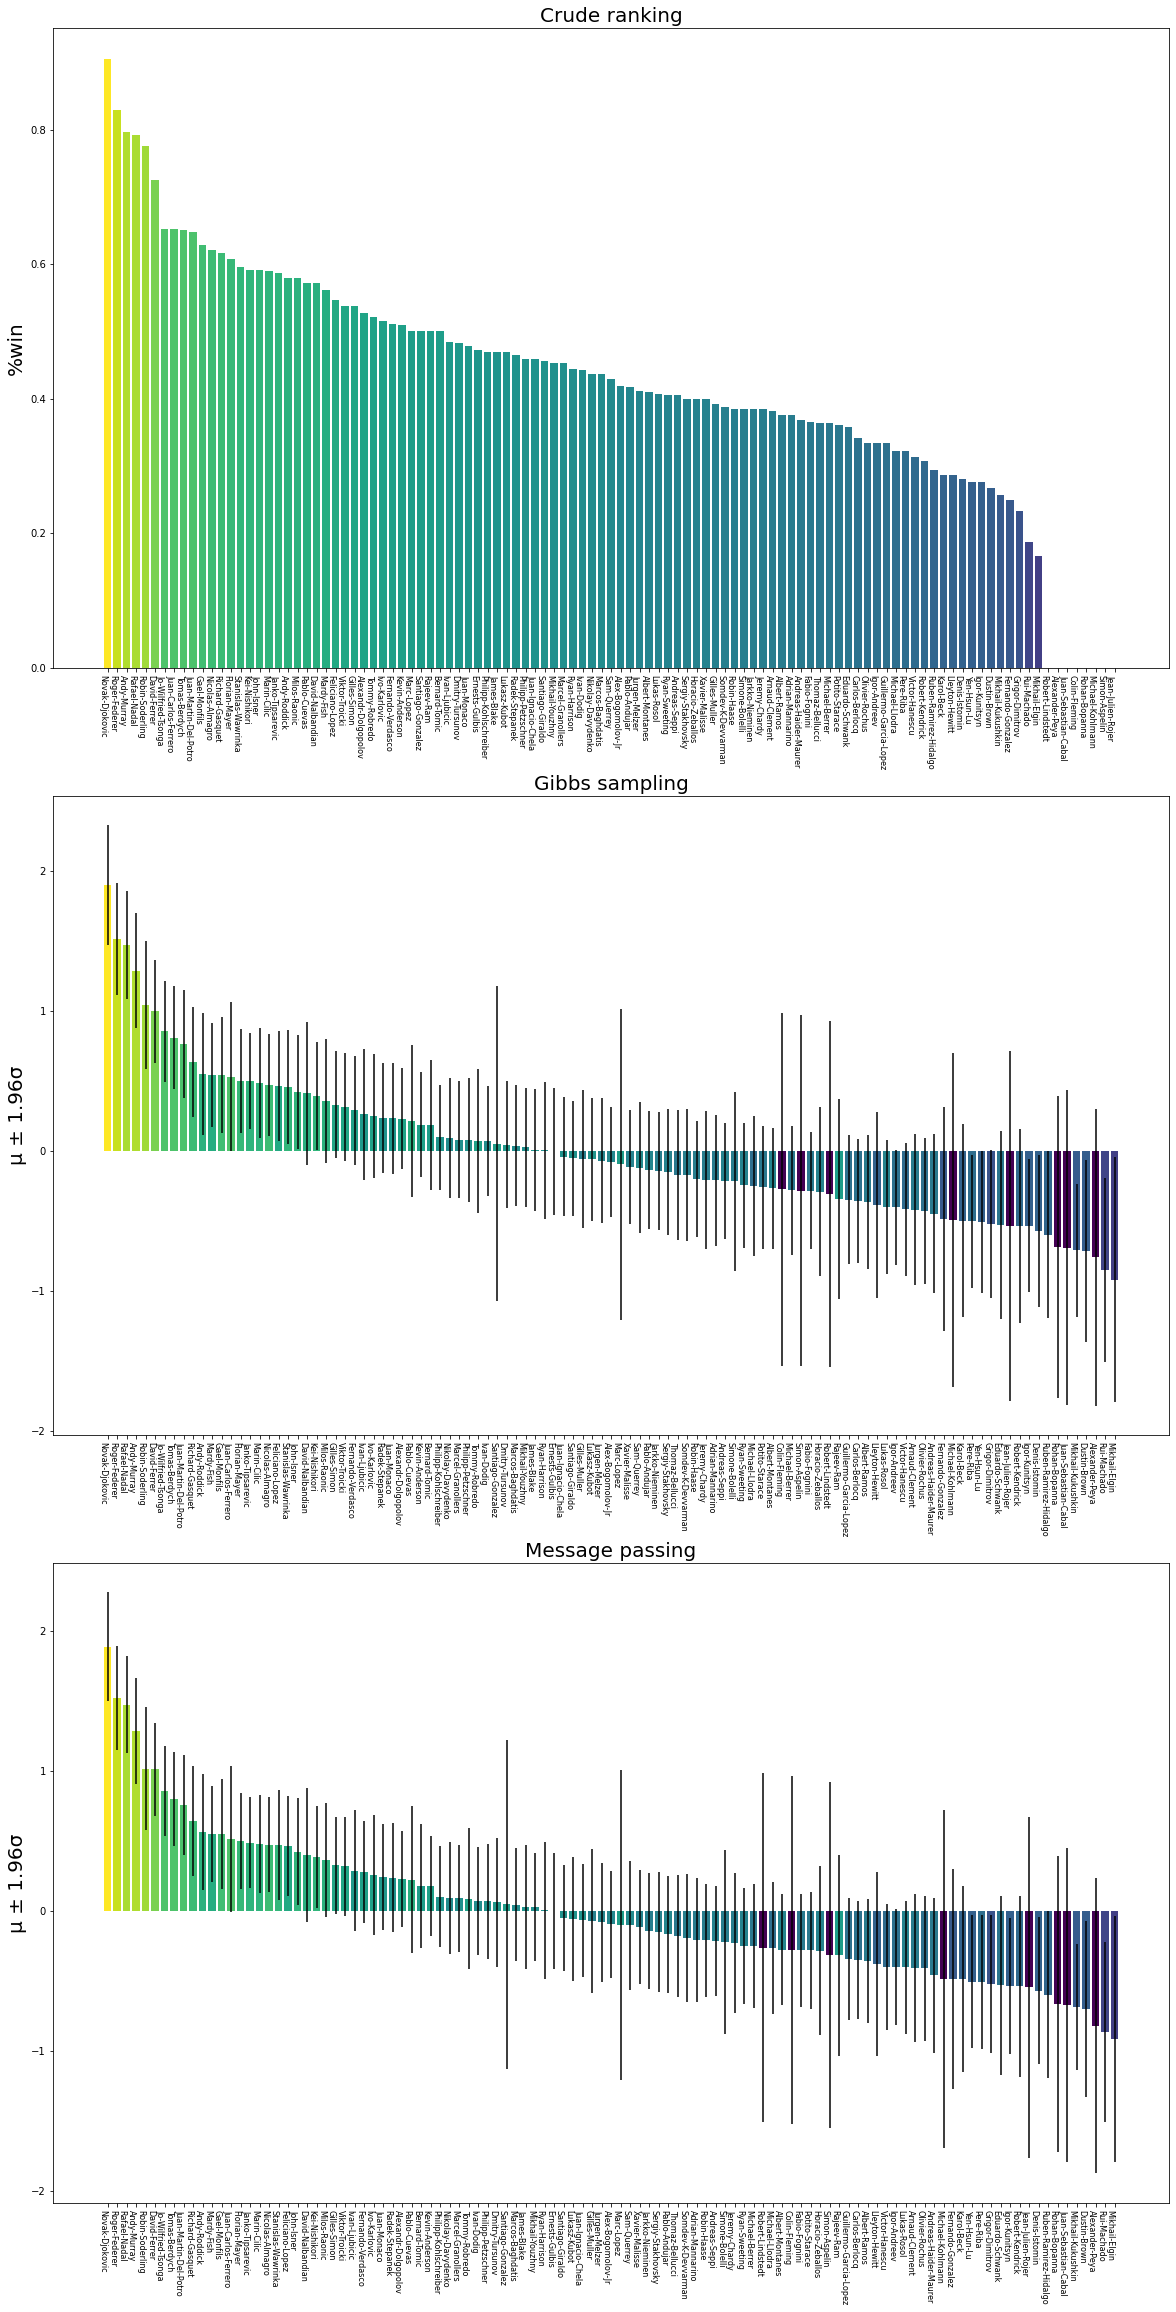

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(20, 40))
x = np.arange(M)

rank_order = np.argsort(score)[::-1]
cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
cmap_rescaled = cmap(rescale(score[rank_order]))
colour_dict = dict(zip(W[rank_order].tolist(), cmap_rescaled.tolist()))
colours = [colour_dict[player] for player in W[rank_order]]
axes[0].bar(x, score[rank_order], color=colours, align='center', width=.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(W[rank_order], rotation=-90, ha='right', fontsize=8)
axes[0].set_ylabel('%win', fontsize=20)
axes[0].set_title('Crude ranking', fontsize=20)

mean_skills_gibbs = np.mean(ws[120:, :], axis=0)
std_skills_gibbs = 1.96 * np.std(ws[120:, :], axis=0)
rank_order = np.argsort(mean_skills_gibbs)[::-1]
colours = [colour_dict[player] for player in W[rank_order]]
axes[1].bar(x, mean_skills_gibbs[rank_order], yerr=std_skills_gibbs[rank_order], color=colours, align='center', width=.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(W[rank_order], rotation=-90, ha='right', fontsize=8)
axes[1].set_ylabel('μ ± 1.96σ', fontsize=20)
axes[1].set_title('Gibbs sampling', fontsize=20)

mean_skills_ep = means[-1]
std_skills_ep = 1.96 * stds[-1]
rank_order = np.argsort(mean_skills_ep)[::-1]
colours = [colour_dict[player] for player in W[rank_order]]
axes[2].bar(x, mean_skills_ep[rank_order], yerr=std_skills_ep[rank_order], color=colours, align='center', width=.8)
axes[2].set_xticks(x)
axes[2].set_xticklabels(W[rank_order], rotation=-90, ha='right', fontsize=8)
axes[2].set_ylabel('μ ± 1.96σ', fontsize=20)
axes[2].set_title('Message passing', fontsize=20)

plt.savefig('Question(c)/skills_comparison.png', bbox_inches='tight')
plt.show()

In [14]:
# Question (d)
with open('Question(a)/skills_wrt_epochs.pickle', 'rb') as f:
    ws = pickle.load(f)

init_random_seed()
    
w_nadal = ws[120::10, 0]
w_djokovic = ws[120::10, 15]

mean_w_nadal_gibbs = np.mean(w_nadal)
mean_w_djokovic_gibbs = np.mean(w_djokovic)
μ = mean_w_nadal_gibbs - mean_w_djokovic_gibbs

var_w_nadal_gibbs = np.var(w_nadal)
var_w_djokovic_gibbs = np.var(w_djokovic)
σ = np.sqrt(var_w_nadal_gibbs + var_w_djokovic_gibbs)

print('Gibbs sampling:')
print(f'P(Nadal has higher skill) = {scipy.stats.norm.sf(0, loc=μ, scale=σ)}')
print(f'P(Nadal wins a game) = {scipy.stats.norm.sf(0, loc=μ, scale=σ + 1)}')

Gibbs sampling:
P(Nadal has higher skill) = 0.07533425828841056
P(Nadal wins a game) = 0.3680247745077771


In [15]:
init_random_seed()

print('Gibbs sampling, direct:')
print(f'P(Nadal has higher skill) = {np.mean(w_nadal > w_djokovic)}')
print(f'P(Nadal wins a game) = {np.mean(w_nadal - w_djokovic + np.random.normal(size=len(w_nadal)) > 0)}')

Gibbs sampling, direct:
P(Nadal has higher skill) = 0.06060606060606061
P(Nadal wins a game) = 0.2828282828282828


In [16]:
with open('Question(b)/means.pickle', 'rb') as f:
    means = pickle.load(f)
with open('Question(b)/stds.pickle', 'rb') as f:
    stds = pickle.load(f)

init_random_seed()

mean_w_nadal_ep = means[-1, 0]
mean_w_djokovic_ep = means[-1, 15]
μ = mean_w_nadal_ep - mean_w_djokovic_ep

var_w_nadal_ep = stds[-1, 0] ** 2
var_w_djokovic_ep = stds[-1, 15] ** 2
σ = np.sqrt(var_w_nadal_ep + var_w_djokovic_ep)

print('Message passing:')
print(f'P(Nadal has higher skill) = {scipy.stats.norm.sf(0, loc=μ, scale=σ)}')
print(f'P(Nadal wins a game) = {scipy.stats.norm.sf(0, loc=μ, scale=σ + 1)}')

Message passing:
P(Nadal has higher skill) = 0.06017785849720443
P(Nadal wins a game) = 0.3719284419079504


In [44]:
# actural games won by Nadal vs Djokovic
np.dot((G[:,0] == 0).astype(int), (G[:,1] == 15).astype(int))

0

In [45]:
# actural games won by Djokovic vs Nadal
np.dot((G[:,0] == 15).astype(int), (G[:,1] == 0).astype(int))

6

In [17]:
with open('Question(a)/skills_wrt_epochs.pickle', 'rb') as f:
    ws = pickle.load(f)

init_random_seed()
skills_gibbs = np.zeros((M, M))
skills_gibbs_direct = np.zeros((M, M))
performances_gibbs = np.zeros((M, M))
performances_gibbs_direct = np.zeros((M, M))

for player_i in range(M):
    for player_j in range(player_i):
        w_i = ws[120::10, player_i]
        w_j = ws[120::10, player_j]
        
        mean_w_i = np.mean(w_i)
        mean_w_j = np.mean(w_j)
        μ = mean_w_i - mean_w_j
        
        var_w_i = np.var(w_i)
        var_w_j = np.var(w_j)
        σ = np.sqrt(var_w_i + var_w_j)
        
        skills_gibbs[player_i, player_j] = scipy.stats.norm.sf(0, loc=μ, scale=σ)
        skills_gibbs[player_j, player_i] = scipy.stats.norm.sf(0, loc=-μ, scale=σ)
        skills_gibbs_direct[player_i, player_j] = np.mean(w_i > w_j)
        skills_gibbs_direct[player_j, player_i] = np.mean(w_j > w_i)
        performances_gibbs[player_i, player_j] = scipy.stats.norm.sf(0, loc=μ, scale=σ + 1)
        performances_gibbs[player_j, player_i] = scipy.stats.norm.sf(0, loc=-μ, scale=σ + 1)
        performances_gibbs_direct[player_i, player_j] = np.mean(w_i - w_j + np.random.normal(size=len(w_i)) > 0)
        performances_gibbs_direct[player_j, player_i] = np.mean(w_j - w_i + np.random.normal(size=len(w_j)) > 0)
        
avg_skills_gibbs = [np.sum(skills_gibbs[i]) / (M - 1) for i in range(M)]
avg_skills_gibbs_direct = [np.sum(skills_gibbs_direct[i]) / (M - 1) for i in range(M)]
avg_performances_gibbs = [np.sum(performances_gibbs[i]) / (M - 1) for i in range(M)]
avg_performances_gibbs_direct = [np.sum(performances_gibbs_direct[i]) / (M - 1) for i in range(M)]

In [18]:
with open('Question(b)/means.pickle', 'rb') as f:
    means = pickle.load(f)
with open('Question(b)/stds.pickle', 'rb') as f:
    stds = pickle.load(f)

init_random_seed()
skills_ep = np.zeros((M, M))
performances_ep = np.zeros((M, M))

for player_i in range(M):
    for player_j in range(player_i):
        mean_w_i = means[-1, player_i]
        mean_w_j = means[-1, player_j]
        μ = mean_w_i - mean_w_j
        
        var_w_i = stds[-1, player_i] ** 2
        var_w_j = stds[-1, player_j] ** 2
        σ = np.sqrt(var_w_i + var_w_j)
        
        skills_ep[player_i, player_j] = scipy.stats.norm.sf(0, loc=μ, scale=σ)
        skills_ep[player_j, player_i] = scipy.stats.norm.sf(0, loc=-μ, scale=σ)
        performances_ep[player_i, player_j] = scipy.stats.norm.sf(0, loc=μ, scale=σ + 1)
        performances_ep[player_j, player_i] = scipy.stats.norm.sf(0, loc=-μ, scale=σ + 1)
    
avg_skills_ep = [np.sum(skills_ep[i]) / (M - 1) for i in range(M)]
avg_performances_ep = [np.sum(performances_ep[i]) / (M - 1) for i in range(M)]

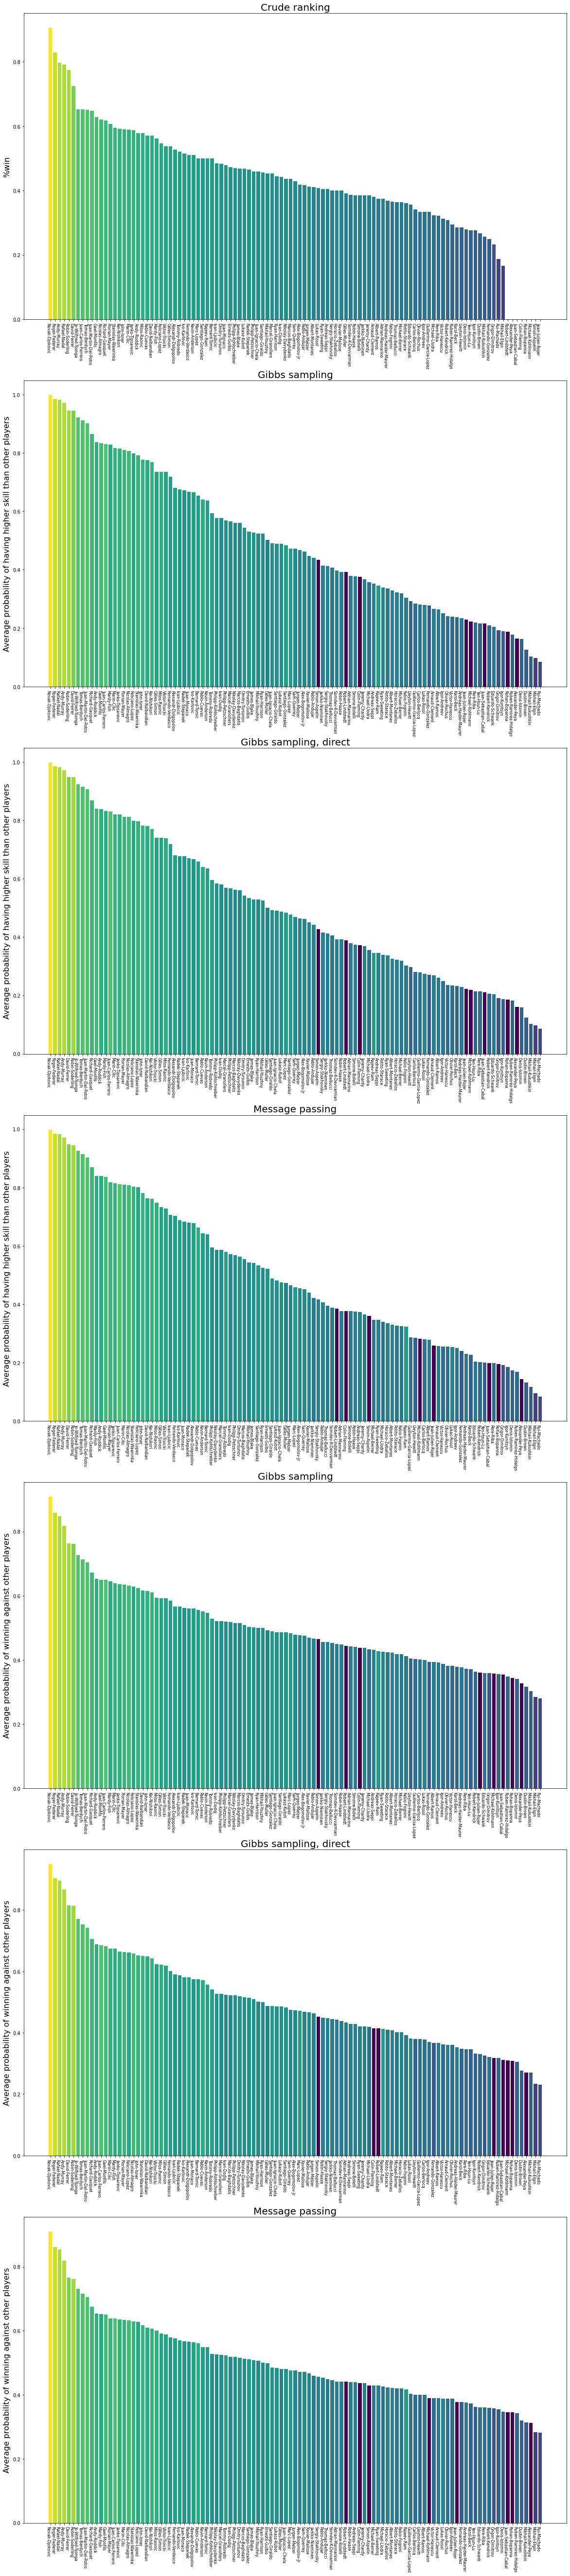

In [19]:
fig, axes = plt.subplots(7, 1, figsize=(20, 95))
x = np.arange(M)

rank_order = np.argsort(score)[::-1]
cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
cmap_rescaled = cmap(rescale(score[rank_order]))
colour_dict = dict(zip(W[rank_order].tolist(), cmap_rescaled.tolist()))
colours = [colour_dict[player] for player in W[rank_order]]
axes[0].bar(x, score[rank_order], color=colours, align='center', width=.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(W[rank_order], rotation=-90, ha='right', fontsize=8)
axes[0].set_ylabel('%win', fontsize=16)
axes[0].set_title('Crude ranking', fontsize=20)

for i, rank_obj in enumerate([avg_skills_gibbs, avg_skills_gibbs_direct, avg_skills_ep, 
                              avg_performances_gibbs, avg_performances_gibbs_direct, avg_performances_ep]):
    rank_order = np.argsort(rank_obj)[::-1]
    colours = [colour_dict[player] for player in W[rank_order]]
    axes[i + 1].bar(x, np.array(rank_obj)[rank_order], color=colours, align='center', width=.8)
    axes[i + 1].set_xticks(x)
    axes[i + 1].set_xticklabels(W[rank_order], rotation=-90, ha='right', fontsize=8)
    if i < 3:
        axes[i + 1].set_ylabel('Average probability of having higher skill than other players', fontsize=16)
    else:
        axes[i + 1].set_ylabel('Average probability of winning against other players', fontsize=16)

axes[1].set_title('Gibbs sampling', fontsize=20)
axes[2].set_title('Gibbs sampling, direct', fontsize=20)
axes[3].set_title('Message passing', fontsize=20)
axes[4].set_title('Gibbs sampling', fontsize=20)
axes[5].set_title('Gibbs sampling, direct', fontsize=20)
axes[6].set_title('Message passing', fontsize=20)

plt.savefig('Question(d)/rankings_comparison.png', bbox_inches='tight')
plt.show()

In [22]:
# Question (e)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

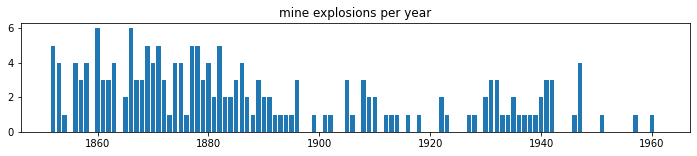

In [24]:
url = 'https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/coal.txt'
coal = pd.read_csv(url, names=['date'], parse_dates=['date'])

# Count number of explosions by year, and fill in missing years with count=0
counts = coal['date'].groupby(coal['date'].dt.year).apply(len)
y,Y = np.min(counts.index.values), np.max(counts.index.values)
df = pd.DataFrame({'count': np.zeros(Y-y+1, dtype=int)}, index=np.arange(y,Y+1))
df.index.name = 'year'
df.loc[counts.index, 'count'] = counts
# Discard first and last year (for which counts might be incomplete)
df = df.reset_index()
df = df.loc[(df['year']>y) & (df['year']<Y)]

with matplotlib.rc_context({'figure.figsize': [12,2]}):
    plt.bar(df['year'].values, df['count'].values)
    plt.title('mine explosions per year')
plt.show()

In [71]:
init_random_seed()
epochs = 2000

N = len(df)
x = df['count']
a = np.mean(x)
b = 1
# Here I set df['year'][1] to be year 0 as opposed to my maths derivations
θ = 1900 - df['year'][1]  # prior θ
λs = []
μs = []
θs = [θ]

for epoch in range(epochs):
    # Sample λ (rate before change point) given x, θ, a and b 
    λ = np.random.gamma(
        shape=a + np.sum(x[:θ + 1]),
        scale=1 / (b + θ)
    )
    λs.append(λ)
    
    # Sample μ (rate after change point) given x, θ, a and b 
    μ = np.random.gamma(
        shape=a + np.sum(x[θ + 1:]),
        scale=1 / (b + N - θ)
    )
    μs.append(μ)
    
    # Sample θ given x, λ and μ
    θ_probs = np.array([(λ ** np.sum(x[:t + 1])) * np.exp(-t * λ) * (μ ** np.sum(x[t + 1:])) * np.exp(-(N - t) * μ)
                         for t in range(N)])
    θ_probs /= np.sum(θ_probs)
    θ = np.random.choice(a=np.array(df['year'] - df['year'][1]), p=θ_probs)
    θs.append(θ)
    
    IPython.display.clear_output(wait=True)
    print(f'{epoch + 1}/{epochs} epochs completed.')

λs = np.stack(λs)
with open('Question(e)/lambda_wrt_epochs.pickle', 'wb') as f:
    pickle.dump(λs, f)
μs = np.stack(μs)
with open('Question(e)/mu_wrt_epochs.pickle', 'wb') as f:
    pickle.dump(μs, f)
θs = np.stack(θs)
with open('Question(e)/theta_wrt_epochs.pickle', 'wb') as f:
    pickle.dump(θs, f)

2000/2000 epochs completed.


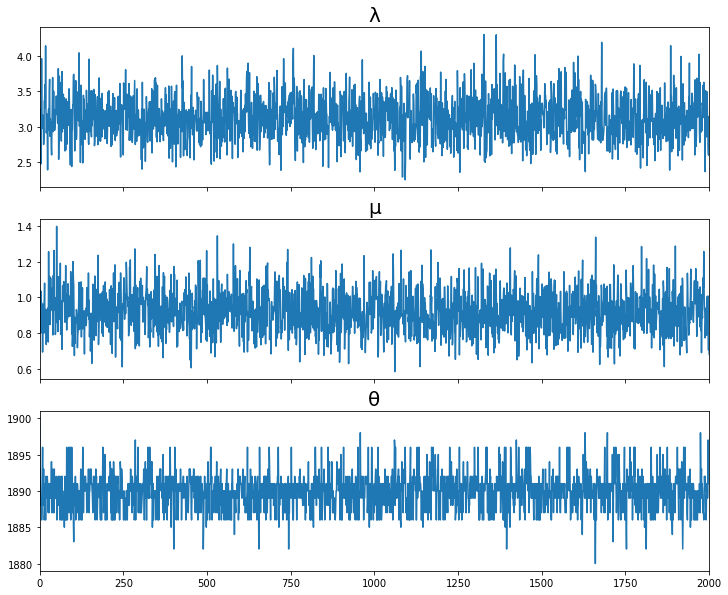

In [74]:
with open('Question(e)/lambda_wrt_epochs.pickle', 'rb') as f:
    λs = pickle.load(f)
with open('Question(e)/mu_wrt_epochs.pickle', 'rb') as f:
    μs = pickle.load(f)
with open('Question(e)/theta_wrt_epochs.pickle', 'rb') as f:
    θs = pickle.load(f)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(np.arange(1, epochs + 1), λs)
axes[0].set_xlim(0, epochs)
axes[0].set_title('λ', fontsize=20)

axes[1].plot(np.arange(1, epochs + 1), μs)
axes[1].set_xlim(0, epochs)
axes[1].set_title('μ', fontsize=20)

axes[2].plot(np.arange(0, epochs + 1), θs + df['year'][1])
axes[2].set_xlim(0, epochs)
axes[2].set_title('θ', fontsize=20)

plt.savefig('Question(e)/lambda_mu_theta_wrt_epochs.png', bbox_inches='tight')
plt.show()

In [79]:
np.mean(λs), np.std(λs), np.mean(λs) - 1.96 * np.std(λs), np.mean(λs) + 1.96 * np.std(λs)

(3.129575382044318, 0.3058006547949904, 2.5302060986461368, 3.728944665442499)

In [80]:
np.mean(μs), np.std(μs), np.mean(μs) - 1.96 * np.std(μs), np.mean(μs) + 1.96 * np.std(μs)

(0.9209425271791665,
 0.11903020388729012,
 0.6876433275600778,
 1.1542417267982552)

In [81]:
np.mean(θs + df['year'][1]), np.std(θs + df['year'][1]), np.mean(θs + df['year'][1]) - 1.96 * np.std(θs + df['year'][1]), np.mean(θs + df['year'][1]) + 1.96 * np.std(θs + df['year'][1])

(1889.911544227886, 2.488488572704258, 1885.0341066253857, 1894.7889818303863)

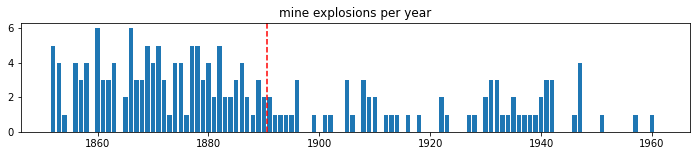

In [86]:
with matplotlib.rc_context({'figure.figsize': [12,2]}):
    plt.bar(df['year'].values, df['count'].values)
    plt.title('mine explosions per year')
    plt.axvline(1890.5, color='r', linestyle='--')
plt.savefig('Question(e)/mine_explosions_with_changing_point.png', bbox_inches='tight')
plt.show()